In [128]:
# Utilities and imports
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def mae(a,b):
    return np.mean(np.abs(a-b))

def rmse(a,b):
    return np.sqrt(np.mean((a-b)**2))


In [129]:
# Load CSV and prepare DataFrame (fast, safe date parsing)
df2 = pd.read_csv(Path('TSLA.csv'), parse_dates=['Date'])
df2 = df2.sort_values('Date').set_index('Date')
df2 = df2[['Open','High','Low','Close','Volume']].astype('float32')
df2.head()

,Open,High,Low,Close,Volume
Date,,,,,
2010-06-29,1.266667,1.666667,1.169333,1.592667,281494496.0
2010-06-30,1.719333,2.028000,1.553333,1.588667,257806496.0
2010-07-01,1.666667,1.728000,1.351333,1.464000,123282000.0
2010-07-02,1.533333,1.540000,1.247333,1.280000,77097000.0
2010-07-06,1.333333,1.333333,1.055333,1.074000,103003504.0


In [130]:
# Sequence parameters
FEATURES = ['Open','High','Low','Close','Volume']
TARGET = 'Close'
LOOKBACK = 20

In [131]:
# Sequence builder: returns dates, X (N, LOOKBACK, features), y (N,)
def make_sequences(df, lookback=LOOKBACK, feature_cols=FEATURES, target_col=TARGET):
    values = df[feature_cols].to_numpy(dtype=np.float32)
    target = df[target_col].to_numpy(dtype=np.float32)
    dates = df.index.to_numpy()
    X, y, d = [], [], []
    for i in range(lookback, len(df)):
        X.append(values[i-lookback:i])
        y.append(target[i])
        d.append(dates[i])
    return np.array(d), np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

seq_dates, seq_X, seq_y = make_sequences(df2, lookback=LOOKBACK)
print('Sequences shapes:', seq_dates.shape, seq_X.shape, seq_y.shape)

Sequences shapes: (3545,) (3545, 20, 5) (3545,)


In [132]:
# Time-based split and baseline (last-close)
q_80 = int(len(seq_dates) * 0.8)
q_90 = int(len(seq_dates) * 0.9)
dates_train, X_train, y_train = seq_dates[:q_80], seq_X[:q_80], seq_y[:q_80]
dates_val, X_val, y_val = seq_dates[q_80:q_90], seq_X[q_80:q_90], seq_y[q_80:q_90]
dates_test, X_test, y_test = seq_dates[q_90:], seq_X[q_90:], seq_y[q_90:]

close_idx = FEATURES.index('Close')
baseline_test = X_test[:, -1, close_idx]
print('Baseline (last-close) MAE:', mae(y_test, baseline_test), 'RMSE:', rmse(y_test, baseline_test))

Baseline (last-close) MAE: 5.2673516 RMSE: 7.188899


In [133]:
# Scale X using train stats (numpy) and scale y
n_s, look, n_feat = X_train.shape
X_train_2d = X_train.reshape(-1, n_feat)
train_mean = X_train_2d.mean(axis=0)
train_std = X_train_2d.std(axis=0)
train_std[train_std == 0] = 1.0
def scale_X(X):
    X2d = X.reshape(-1, X.shape[-1])
    Xs = ((X2d - train_mean) / train_std).reshape(X.shape).astype(np.float32)
    return Xs
X_train_s, X_val_s, X_test_s = map(scale_X, [X_train, X_val, X_test])

y_mean = y_train.mean()
y_std = y_train.std()
if y_std == 0: y_std = 1.0
y_train_s = ((y_train - y_mean)/y_std).astype(np.float32)
y_val_s = ((y_val - y_mean)/y_std).astype(np.float32)
y_test_s = ((y_test - y_mean)/y_std).astype(np.float32)

print('Scaled shapes:', X_train_s.shape, X_val_s.shape, X_test_s.shape)

Scaled shapes: (2836, 20, 5) (354, 20, 5) (355, 20, 5)


In [134]:
# Build and train LSTM (sequence model)
import tensorflow as tf
tf.random.set_seed(42)
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

model_seq = Sequential([
    layers.Input((LOOKBACK, len(FEATURES))),
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])
model_seq.compile(loss='mse', optimizer=Adam(1e-3), metrics=['mean_absolute_error'])
callbacks = [EarlyStopping(patience=10, restore_best_weights=True), ReduceLROnPlateau(patience=5, factor=0.5)]
history_seq = model_seq.fit(X_train_s, y_train_s, validation_data=(X_val_s, y_val_s), epochs=80, batch_size=16, callbacks=callbacks, verbose=1, shuffle=False)


Epoch 1/80
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0632 - mean_absolute_error: 0.1108 - val_loss: 1.4953 - val_mean_absolute_error: 0.9938 - learning_rate: 0.0010
Epoch 2/80
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0615 - mean_absolute_error: 0.1026 - val_loss: 0.6038 - val_mean_absolute_error: 0.5892 - learning_rate: 0.0010
Epoch 3/80
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0274 - mean_absolute_error: 0.0785 - val_loss: 0.2220 - val_mean_absolute_error: 0.3836 - learning_rate: 0.0010
Epoch 4/80
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0255 - mean_absolute_error: 0.0687 - val_loss: 0.2615 - val_mean_absolute_error: 0.4205 - learning_rate: 0.0010
Epoch 5/80
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0419 - mean_absolute_error: 0.0782 - val_loss: 0.2834 - val_mean_absolute_error: 0.4273 - learning_rate: 0.0010
Epoch 6/80
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0335 - mean_absolute_error: 0.0775 - val_loss: 0.5330 - val_mean_abs

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Model test MAE: 6.837889 RMSE: 9.080363
Baseline test MAE: 5.2673516
Improvement in MAE: -1.5705376


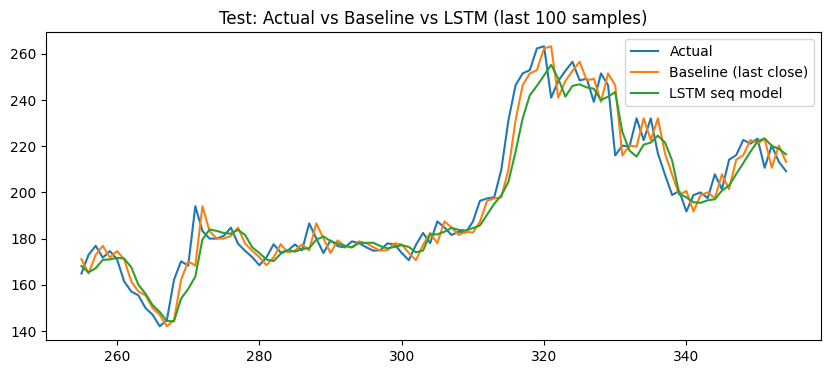

In [135]:
# Evaluate on test set and plot comparison
y_pred_s = model_seq.predict(X_test_s).ravel()
y_pred = (y_pred_s * y_std) + y_mean
print('Model test MAE:', mae(y_test, y_pred), 'RMSE:', rmse(y_test, y_pred))
print('Baseline test MAE:', mae(y_test, baseline_test))
print('Improvement in MAE:', mae(y_test, baseline_test) - mae(y_test, y_pred))

# plot last 100 samples
idxs = np.arange(len(y_test))
plt.figure(figsize=(10,4))
plt.plot(idxs[-100:], y_test[-100:], label='Actual')
plt.plot(idxs[-100:], baseline_test[-100:], label='Baseline (last close)')
plt.plot(idxs[-100:], y_pred[-100:], label='LSTM seq model')
plt.legend()
plt.title('Test: Actual vs Baseline vs LSTM (last 100 samples)')
plt.show()

In [136]:
print(f"Baseline MAE: {mae(y_test, baseline_test):.2f}")
print(f"LSTM MAE: {mae(y_test, y_pred):.2f}")
print(f"Improvement: {mae(y_test, baseline_test) - mae(y_test, y_pred):.2f}")

Baseline MAE: 5.27
LSTM MAE: 6.84
Improvement: -1.57
